# Plots for Evaluating the CSHT vs ASC speed

In [1]:
import cosima_cookbook as cc
from cosima_cookbook import distributed as ccd
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import glob,os
import cmocean.cm as cmocean
from gsw import sigma0
from xhistogram.xarray import histogram

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
client = Client(n_workers=28, memory_limit='190GiB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 5.20 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33941,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 5.20 TiB
Comm: tcp://127.0.0.1:45127,Total threads: 1
Dashboard: /proxy/39391/status,Memory: 190.00 GiB
Nanny: tcp://127.0.0.1:39455,


In [3]:
#Importing  CSHT
CSHT_σ = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/WMbins_daily_rho/*')

# monthly mean
CSHT_σmonthly=CSHT_σ.resample(time='1M').mean()

# Long term mean
CSHT_σmean=CSHT_σ.mean()

0.3.0


In [4]:
CSHT_ZCmonthly = (CSHT_σmonthly.zonal_convergence + CSHT_σmonthly.binned_cross_slope_heat_trans)

In [5]:
#Importing ASC speeds   - UNBINNED
ASC_σ = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/ASC_speed/daily_rho/WMbins_daily_rho/*')
# monthly mean
ASC_σmonthly=ASC_σ.resample(time='1M').mean()
# Long term mean
ASC_σmean=ASC_σ.mean()



#Importing ASC speeds   - BINNED
ASC_σ_3deg = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/ASC_speed/daily_rho/WMbins_daily_rho_3deg/*')
# monthly mean
ASC_σmonthly_3deg=ASC_σ_3deg.resample(time='1M').mean()
# Long term mean
ASC_σmean_3deg=ASC_σ_3deg.mean()



In [6]:
#Correction factors
factor_σ=CSHT_σmean.unbinned_heat_transp_across_contour.sum()/ (CSHT_σmean.zonal_convergence.sum() + CSHT_σmean.binned_cross_slope_heat_trans.sum())
factor_σ.values


array(0.01988431)

Let's do a first simple plot of circumpolar ASC

(-120.0, 70.0)

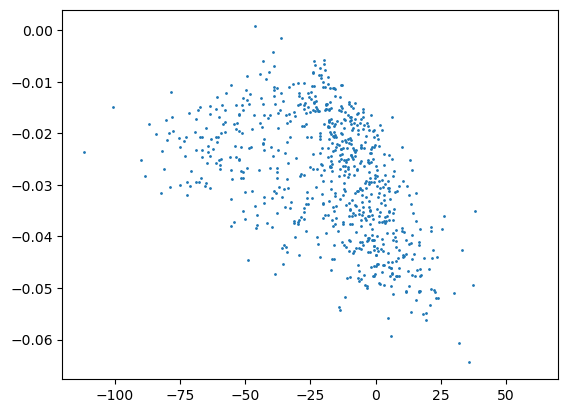

In [7]:
plt.scatter(CSHT_σmonthly.unbinned_heat_transp_across_contour.sum(('contour_index','potrho0'))/1e12,\
           ASC_σmonthly.u_along_contour.mean(('contour_index','potrho0')),1)
plt.xlim(-120,70)

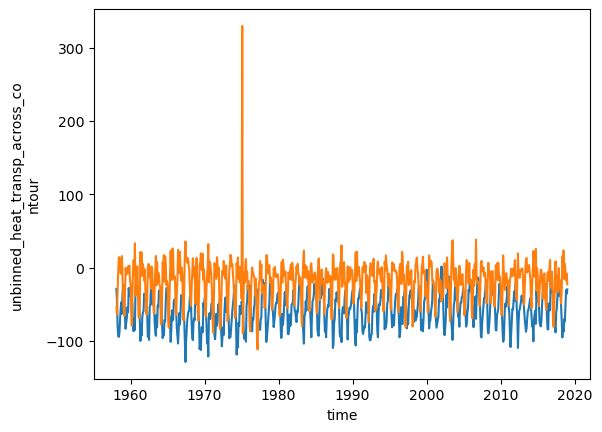

In [8]:
(ASC_σmonthly.u_along_contour.mean(('contour_index','potrho0'))*2000).plot()
(CSHT_σmonthly.unbinned_heat_transp_across_contour.sum(('contour_index','potrho0'))/1e12).plot()

In [9]:
mean_mask=xr.open_dataset('/g/data/v45/txs156/ASC_classification/clustering_mask_time_mean.nc').rename({'lon':'lon_bin_midpoints'})
mean_mask=mean_mask.regimes_mask.load()

In [10]:
mean_mask.regime.where(mean_mask.regime!='Reverse',drop=True)

<xarray.DataArray 'regime' (regime: 2)>
array(['Surface', 'Deep'], dtype=object)
Coordinates:
  * regime   (regime) <U7 'Surface' 'Deep'

In [11]:
#Full daily correlation coefficient
ASC_binned_full_column= ASC_σ_3deg.U_along_contour_binned.mean(('potrho0'))
CSHT_binned_full_column = CSHT_σ.binned_cross_slope_heat_trans.sum(('potrho0'))/1e12
Rcorr = xr.corr(ASC_binned_full_column, CSHT_binned_full_column, dim='time')

#Full monthly correlation coefficient
ASC_binned_full_column_monthly= ASC_σmonthly_3deg.U_along_contour_binned.mean(('potrho0'))
CSHT_binned_full_column_monthly = CSHT_σmonthly.binned_cross_slope_heat_trans.sum(('potrho0'))/1e12
Rcorr_monthly = xr.corr(ASC_binned_full_column_monthly, CSHT_binned_full_column_monthly, dim='time')


#Full seasonal interannual
ASC_binned_full_column_annual = ASC_σmonthly_3deg.U_along_contour_binned.resample(time='1Y').mean().mean(('potrho0'))
CSHT_binned_full_column_annual = CSHT_σmonthly.binned_cross_slope_heat_trans.resample(time='1Y').mean().sum(('potrho0'))/1e12
Rcorr_annual = xr.corr(ASC_binned_full_column_annual, CSHT_binned_full_column_annual, dim='time')

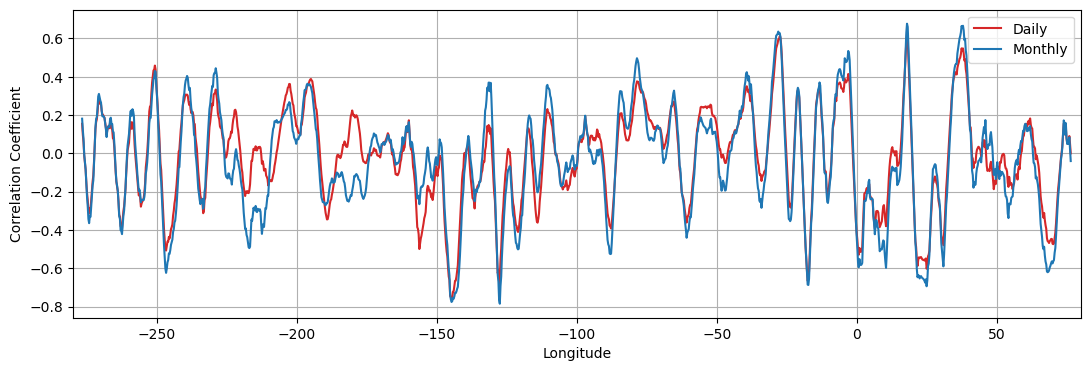

In [12]:
plt.figure(figsize=(13,4))
Rcorr.rolling(lon_bin_midpoints=15,center=True).mean().plot(color='tab:red',label='Daily')
Rcorr_monthly.rolling(lon_bin_midpoints=15,center=True).mean().plot(color='tab:blue',label='Monthly')
#Rcorr_annual.rolling(lon_bin_midpoints=15,center=True).mean().plot(color='tab:red',label='Interannual')
plt.xlim(-280,80); plt.grid()
plt.xlabel('Longitude'); plt.ylabel('Correlation Coefficient')
plt.legend()

How does it look like if we add the zonal convergence?

In [13]:
#Full daily correlation coefficient
CSHT_binned_full_columnZC = ((CSHT_σ.binned_cross_slope_heat_trans + CSHT_σ.zonal_convergence)*factor_σ).sum(('potrho0'))/1e12
CSHT_binned_full_columnZC
Rcorr_ZC = xr.corr(ASC_binned_full_column, CSHT_binned_full_columnZC, dim='time')

# #Full monthly correlation coefficient
CSHT_binned_full_column_monthlyZC = ((CSHT_σmonthly.binned_cross_slope_heat_trans + CSHT_σmonthly.zonal_convergence)*factor_σ).sum(('potrho0'))/1e12
Rcorr_monthly_ZC = xr.corr(ASC_binned_full_column_monthly, CSHT_binned_full_column_monthlyZC, dim='time')


# #Full seasonal interannual
CSHT_binned_full_column_annualZC = ((CSHT_σmonthly.binned_cross_slope_heat_trans.resample(time='1Y').mean() + \
                                   CSHT_σmonthly.zonal_convergence.resample(time='1Y').mean())*factor_σ).sum(('potrho0'))/1e12
Rcorr_annual_ZC = xr.corr(ASC_binned_full_column_annual, CSHT_binned_full_column_annualZC, dim='time')

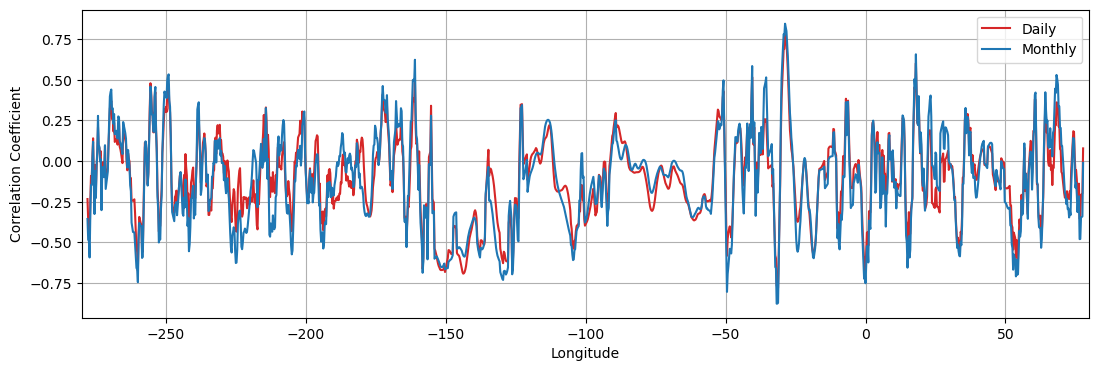

In [14]:
plt.figure(figsize=(13,4))
Rcorr_ZC.rolling(lon_bin_midpoints=5,center=True).mean().plot(color='tab:red',label='Daily')
Rcorr_monthly_ZC.rolling(lon_bin_midpoints=5,center=True).mean().plot(color='tab:blue',label='Monthly')
#Rcorr_annual.rolling(lon_bin_midpoints=15,center=True).mean().plot(color='tab:red',label='Interannual')
plt.xlim(-280,80); plt.grid()
plt.xlabel('Longitude'); plt.ylabel('Correlation Coefficient')
plt.legend()

How does it look like for the Totem ice shelf

Let's try to do the xhistogram

In [15]:
ASC_CDW = ASC_σ_3deg.isel(potrho0=-4).U_along_contour_binned * mean_mask
ASC_CDW.name='ASC'
CSHT_CDWZC = ((CSHT_σ.binned_cross_slope_heat_trans + CSHT_σ.zonal_convergence)*factor_σ).isel(potrho0=-4)  * mean_mask
CSHT_CDW = ((CSHT_σ.binned_cross_slope_heat_trans)*factor_σ).isel(potrho0=-4)  * mean_mask
CSHT_CDW.name= 'CSHT'
CSHT_CDWZC.name= 'CSHT'
Occurence_count=((CSHT_CDW.fillna(0) * 0)+1)  * mean_mask

Occurence_count.name='count'

In [16]:
#target bins will be:
targetbins = np.append(np.linspace(-0.5,-0.2,25),np.linspace(-0.19,.3,20))
targetbins

array([-0.5       , -0.4875    , -0.475     , -0.4625    , -0.45      ,
       -0.4375    , -0.425     , -0.4125    , -0.4       , -0.3875    ,
       -0.375     , -0.3625    , -0.35      , -0.3375    , -0.325     ,
       -0.3125    , -0.3       , -0.2875    , -0.275     , -0.2625    ,
       -0.25      , -0.2375    , -0.225     , -0.2125    , -0.2       ,
       -0.19      , -0.16421053, -0.13842105, -0.11263158, -0.08684211,
       -0.06105263, -0.03526316, -0.00947368,  0.01631579,  0.04210526,
        0.06789474,  0.09368421,  0.11947368,  0.14526316,  0.17105263,
        0.19684211,  0.22263158,  0.24842105,  0.27421053,  0.3       ])

In [17]:
mean_mask.regime

<xarray.DataArray 'regime' (regime: 3)>
array(['Surface', 'Reverse', 'Deep'], dtype='<U7')
Coordinates:
  * regime   (regime) <U7 'Surface' 'Reverse' 'Deep'

In [18]:
#surface regime
CSHT_ASC_Surface = histogram(ASC_CDW.isel(regime=0) , 
                          bins = [targetbins], 
                          dim = ['time'],
                          weights = CSHT_CDW.isel(regime=0).fillna(0) * Occurence_count.isel(regime=0))\
/histogram(ASC_CDW.isel(regime=0) , 
                          bins = [targetbins], 
                          dim = ['time'],
                          weights = Occurence_count.isel(regime=0))


#surface reverse
CSHT_ASC_Reverse = histogram(ASC_CDW.isel(regime=1) , 
                          bins = [targetbins], 
                          dim = ['time'],
                          weights = CSHT_CDW.isel(regime=1).fillna(0) * Occurence_count.isel(regime=1))\
/histogram(ASC_CDW.isel(regime=1) , 
                          bins = [targetbins], 
                          dim = ['time'],
                          weights = Occurence_count.isel(regime=1))

#surface deep
CSHT_ASC_deep = histogram(ASC_CDW.isel(regime=2) , 
                          bins = [targetbins], 
                          dim = ['time'],
                          weights = CSHT_CDW.isel(regime=2).fillna(0) * Occurence_count.isel(regime=2))\
/histogram(ASC_CDW.isel(regime=2) , 
                          bins = [targetbins], 
                          dim = ['time'],
                          weights = Occurence_count.isel(regime=2))

In [19]:
#surface regime
CSHT_ASC_Surface_1d = histogram(ASC_CDW.isel(regime=0) , 
                          bins = [targetbins], 
                          dim = ['time','lon_bin_midpoints'],
                          weights = CSHT_CDW.isel(regime=0).fillna(0) * Occurence_count.isel(regime=0))\
/histogram(ASC_CDW.isel(regime=0) , 
                          bins = [targetbins], 
                          dim = ['time','lon_bin_midpoints'],
                          weights = Occurence_count.isel(regime=0))


#surface reverse
CSHT_ASC_Reverse_1d  = histogram(ASC_CDW.isel(regime=1) , 
                          bins = [targetbins], 
                          dim = ['time','lon_bin_midpoints'],
                          weights = CSHT_CDW.isel(regime=1).fillna(0) * Occurence_count.isel(regime=1))\
/histogram(ASC_CDW.isel(regime=1) , 
                          bins = [targetbins], 
                          dim = ['time','lon_bin_midpoints'],
                          weights = Occurence_count.isel(regime=1))

#surface deep
CSHT_ASC_deep_1d  = histogram(ASC_CDW.isel(regime=2) , 
                          bins = [targetbins], 
                          dim = ['time','lon_bin_midpoints'],
                          weights = CSHT_CDW.isel(regime=2).fillna(0) * Occurence_count.isel(regime=2))\
/histogram(ASC_CDW.isel(regime=2) , 
                          bins = [targetbins], 
                          dim = ['time','lon_bin_midpoints'],
                          weights = Occurence_count.isel(regime=2))

In [20]:
#With zonal convergence...
CSHT_ASC_Surface_1dZC = histogram(ASC_CDW.isel(regime=0) , 
                          bins = [targetbins], 
                          dim = ['time','lon_bin_midpoints'],
                          weights = CSHT_CDWZC.isel(regime=0).fillna(0) * Occurence_count.isel(regime=0))\
/histogram(ASC_CDW.isel(regime=0) , 
                          bins = [targetbins], 
                          dim = ['time','lon_bin_midpoints'],
                          weights = Occurence_count.isel(regime=0))


#surface reverse
CSHT_ASC_Reverse_1dZC  = histogram(ASC_CDW.isel(regime=1) , 
                          bins = [targetbins], 
                          dim = ['time','lon_bin_midpoints'],
                          weights = CSHT_CDWZC.isel(regime=1).fillna(0) * Occurence_count.isel(regime=1))\
/histogram(ASC_CDW.isel(regime=1) , 
                          bins = [targetbins], 
                          dim = ['time','lon_bin_midpoints'],
                          weights = Occurence_count.isel(regime=1))

#surface deep
CSHT_ASC_deep_1dZC  = histogram(ASC_CDW.isel(regime=2) , 
                          bins = [targetbins], 
                          dim = ['time','lon_bin_midpoints'],
                          weights = CSHT_CDWZC.isel(regime=2).fillna(0) * Occurence_count.isel(regime=2))\
/histogram(ASC_CDW.isel(regime=2) , 
                          bins = [targetbins], 
                          dim = ['time','lon_bin_midpoints'],
                          weights = Occurence_count.isel(regime=2))

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


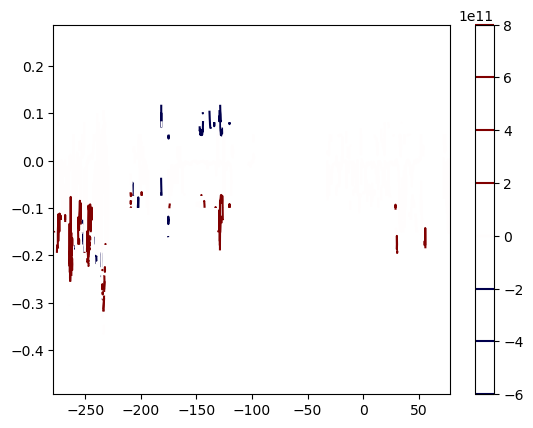

In [21]:
#CSHT_ASC_Surface.plot.contour(x='lon_bin_midpoints');plt.colorbar()
plt.contour(CSHT_ASC_Surface.lon_bin_midpoints,CSHT_ASC_Surface.ASC_bin,CSHT_ASC_Surface.T,vmin=-2e11,vmax=2e11,cmap='seismic')
plt.colorbar()

In [22]:
CSHT_ASC_Surface_1d.load()
CSHT_ASC_Reverse_1d.load()
CSHT_ASC_deep_1d.load()
CSHT_ASC_Surface_1dZC.load()
CSHT_ASC_Reverse_1dZC.load()
CSHT_ASC_deep_1dZC.load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


<xarray.DataArray 'histogram_ASC' (ASC_bin: 44)>
array([            nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan, -4.26955088e+11, -3.04224283e+11,
       -1.24674248e+11, -7.93164675e+10, -1.44283837e+10, -5.92860957e+10,
       -1.93898025e+10, -6.75063054e+09,  1.10545291e+10,  2.35315923e+10,
        2.77213687e+10,  3.38955347e+10,  3.51516332e+10,  2.58021479e+10,
        1.43431172e+10,  1.49068069e+08, -9.11598731e+09, -7.38765885e+09,
       -4.22174419e+10, -7.13701837e+10, -1.00885272e+11, -1.46864135e+11,
       -2.05417074e+11, -3.52859184e+11,             nan,             nan,
                   nan,             nan,             nan,             nan])
Coordinates:
  * ASC_bin  (ASC_bin) float64 -0.4938 -0.4812 -0.4688 ... 0.2355 0.2613 0.2871

Text(0, 0.5, 'CSHT + ZC[$W$]')

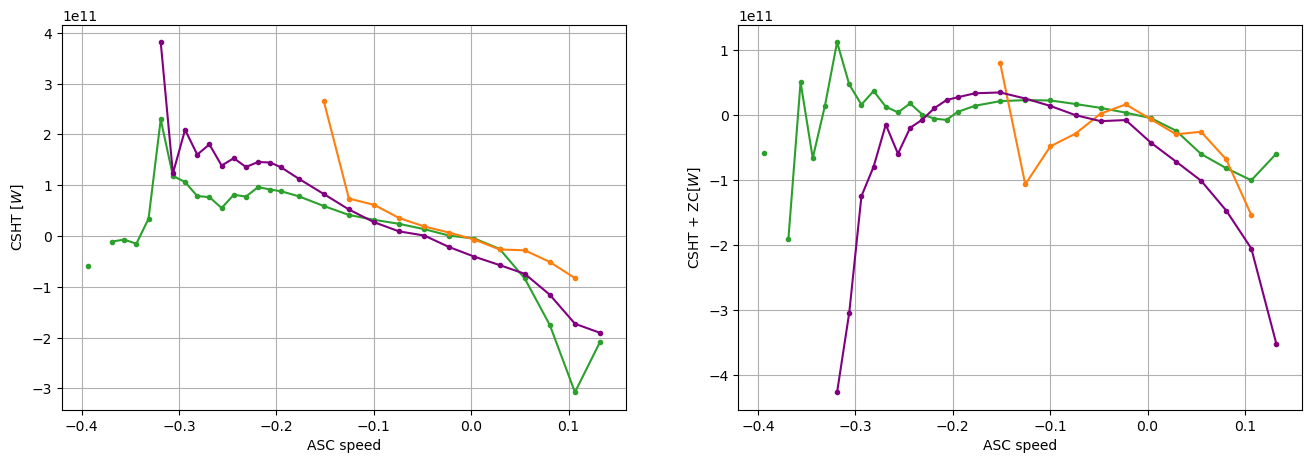

In [23]:
plt.figure(figsize=(16,5))


plt.subplot(1,2,1)
CSHT_ASC_Surface_1d.plot(color='tab:green',marker='.',label='Surface')
CSHT_ASC_Reverse_1d.plot(color='tab:orange',marker='.',label='Reverse')
CSHT_ASC_deep_1d.plot(color='purple',marker='.',label='Deep')
plt.grid()
plt.xlabel('ASC speed')
plt.ylabel(r'CSHT [$W$]')

plt.subplot(1,2,2)
CSHT_ASC_Surface_1dZC.plot(color='tab:green',marker='.',label='Surface')
CSHT_ASC_Reverse_1dZC.plot(color='tab:orange',marker='.',label='Reverse')
CSHT_ASC_deep_1dZC.plot(color='purple',marker='.',label='Deep')
plt.grid()
plt.xlabel('ASC speed')
plt.ylabel(r'CSHT + ZC[$W$]')